In [1]:
!pip install openpiv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 57.6 MB/s eta 0:00:00


In [2]:
from openpiv import tools, pyprocess, validation, filters, scaling, windef
import numpy as np
import zipfile
import imageio
import matplotlib.pyplot as plt
from google.colab import drive, files
from scipy.optimize import curve_fit
from scipy.signal import correlate2d
from scipy import fft
from matplotlib.pyplot import hist as hst
import matplotlib.ticker as tick
import os
import time
from tqdm import tqdm

plt.rcParams.update({'font.size': 14})
plt.rcParams["axes.formatter.limits"] = (-2, 3)

In [4]:
drive.mount('/content/drive')
zip_file = '/content/drive/MyDrive/expdata/data.zip'
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def energy(velocity_field, **kwargs):
    """
    Returns the energy of velocity field
    :param velocity_field: array_like
        3d input array.
    :return: float64
       single scalar describing total energy of velocity field.
    """
    return np.mean(velocity_field ** 2)


def enstrophy(velocity_field, dx, dy, **kwargs):
    """
    Returns the enstrophy of velocity field
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :return: float64
        single scalar describing enstrophy of the velocity field.
    """
    dvy_x = np.gradient(velocity_field[1, :, :], dx, axis=1)
    dvx_y = np.gradient(velocity_field[0, :, :], dy, axis=0)
    rot = dvy_x - dvx_y
    return np.mean(rot ** 2) / 2


def butterworth(x, kf=np.pi, n=16):
    return 1 / (1 + (x / kf) ** (2 * n)) ** 0.5


def low_pass(velocity_field, dx, dy, filter_args=(2/3*np.pi, 16)):
    """
    Return low pass part of the decomposition q = \bar q + \tilde q
    :param velocity_field: array_like
        2d or greater input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for x-axis.
    :param filter_args: tuple
        arguments for the filtering function.
    :return: array_like
        output array of the same shape as input array describing low pass part of velocity.
    """
    shape = np.shape(velocity_field)
    k_x = 2 * np.pi * fft.fftfreq(shape[-1], dx)
    k_y = 2 * np.pi * fft.fftfreq(shape[-2], dy)
    k_xy = np.sqrt(np.square(k_x[np.newaxis, :]) + np.square(k_y[:, np.newaxis]))
    butterworth_wnd = butterworth(k_xy, *filter_args)
    return np.real_if_close(fft.ifft2(fft.fft2(velocity_field) * butterworth_wnd))


def energy_flux(velocity_field, dx, dy, filter_args=(2/3*np.pi, 16)):
    """
    Returns the energy flux for given velocity field at a specific wave number.
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :param filter_args: tuple
        arguments for the filtering function.
    :return: float64
        single scalar describing energy flux.
    """
    v_x_v_y_l = low_pass(velocity_field[0, :, :] * velocity_field[1, :, :], dx, dy, filter_args)
    v2_x_l = low_pass(velocity_field[0, :, :] ** 2, dx, dy, filter_args)
    v2_y_l = low_pass(velocity_field[1, :, :] ** 2, dx, dy, filter_args)
    v_x_l = low_pass(velocity_field[0, :, :], dx, dy, filter_args)
    v_y_l = low_pass(velocity_field[1, :, :], dx, dy, filter_args)
    dv_x_ldy = np.gradient(v_x_l, dy, axis=0)
    dv_y_ldx = np.gradient(v_y_l, dx, axis=1)
    dv_x_ldx = np.gradient(v_x_l, dx, axis=1)
    dv_y_ldy = np.gradient(v_y_l, dy, axis=0)
    flux = (v_x_v_y_l - v_x_l * v_y_l) * (dv_x_ldy + dv_y_ldx) + \
           (v2_y_l - v_y_l ** 2) * dv_y_ldy + (v2_x_l - v_x_l ** 2) * dv_x_ldx
    return np.mean(flux)


def max_energy_flux(velocity_field, dx, dy):
    """
    Returns the wave number that corresponds to energy flux maximum.
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :return: float64
        single scalar describing the wave number at which the maximum of energy flux.
    """
    k_f = np.linspace(0.1, 2 * np.pi, 1000)
    flux_k = [energy_flux(velocity_field, dx, dy, (k_f[i], 16)) for i in range(1000)]
    return k_f[np.argmax(flux_k)]


def double_laplace_rand(mu, sigma, size):
    """
    Generates samples from the double Laplace distribution with specified mean and standard deviation.
    :param mu: float
        the mean of distribution.
    :param sigma: float
        the standard deviation of distribution.
    :param size: tuple of ints
        shape of random numbers array.
    :return: array_like
        random numbers array of given shape.
    """
    dist = np.zeros(2*size[0]*size[1])
    for i in range(2*size[0]*size[1]):
        num = np.random.randint(1, 3)
        if num == 1:
            dist[i] = np.random.laplace(mu, sigma)
        if num == 2:
            dist[i] = np.random.laplace(-mu, sigma)
    return np.reshape(dist, (2, size[0], size[1]))


def dist_by_hist(hist, size):
    """
    Returns a random numbers array of the given shape, with a distribution similar to a histogram.
    :param hist: array_like
        given histogram of distribution of random numbers.
    :param size: tuple of ints
        shape of random numbers array.
    :return: array_like
        random numbers array of given shape and distribution.
    """
    dist = np.zeros(2*size[0]*size[1])
    dx = hist[1][1] - hist[1][0]
    cdf = [np.sum(hist[0][0:i]) * dx for i in range(len(hist[0]))]
    unif = np.random.uniform(0, 1, size=2*size[0]*size[1])
    ind = np.searchsorted(cdf, unif)
    np.place(ind, ind == 500, 499)
    end = int(*np.shape(hist[0]))
    for i in range(2*size[0]*size[1]):
        dist[i] = hist[1][0:end][ind[i] - 1] \
                  + ((hist[1][0:end][ind[i]] - hist[1][0:end][ind[i]-1]) / (cdf[ind[i]] - cdf[ind[i] - 1])) \
                  * (unif[i] - cdf[ind[i]-1])
    np.place(dist, np.isinf(dist), hist[1][end])
    return np.reshape(dist, (2, size[0], size[1]))


def accuracy(func, velocity_field, error, **kwargs):
    """
    Returns calculation error of a given function for specific velocity field and its error.
    :param func: callable
        function for which the error is calculated.
    :param velocity_field: array_like
        3d input array describing the velocity field.
    :param error: array_like
        3d input array describing the error of velocity field.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :return: float
        single scalar describing error of function for specific velocity field and its error.
    """
    delta_f = func(velocity_field+error, **kwargs) - func(velocity_field, **kwargs)
    return delta_f


def vel_error(shape, kind, mu=0.0, st_dev=1.0, hist=None):
    """
    Returns a random error of certain type.
    :param shape: tuple of int
        shape of output array.
    :param kind: string
        type of error distribution.
    :param mu: float64
        mean of error distribution.
    :param st_dev: float64
        standard deviation of error distribution.
    :param hist: histogram
    :return: array_like
        3d output array.
    """
    n_x, n_y = shape[0], shape[1]
    if kind == 'gauss':
        mis = np.random.normal(mu, st_dev, size=(2, n_x, n_y))
        return mis
    if kind == 'laplace':
        mis = np.random.laplace(mu, st_dev/np.sqrt(2), size=(2, n_x, n_y))
        return mis
    if kind == 'double_laplace':
        mis = double_laplace_rand(mu, st_dev/np.sqrt(2), (n_x, n_y))
        return mis
    if kind == 'cdf':
        mis = dist_by_hist(hist, (n_x, n_y))
        return mis


def func_error(k, func, velocity_field, shape, kind, mu=0.0, st_dev=1.0, hist=None, **kwargs):
    """
    Returns array of relative errors for k different samples.
    :param k: int
        number of samples of the error.
    :param func: callable
        function for which the error distribution is calculated.
    :param velocity_field: array_like
        3d input array.
    :param shape: tuple of int
        shape of error array.
    :param kind: string
        type of error distribution.
    :param st_dev: float64
        standard deviation of error distribution.
    :param mu: float64
        mean of error distribution.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :param hist: array_like
        amplitude of velocity error for each velocity vector.
    :return: array_like
        1d array containing absolute errors.
    """
    ac_abs = [accuracy(func, velocity_field, 
                       vel_error(shape, kind, mu=mu, st_dev=st_dev, hist=hist), **kwargs) for i in range(k)]
    return np.array(ac_abs)


def mean(func, k, sigma, velocity_field, kind, **kwargs):
    """
    Returns the standard deviation dependence of mean of distribution.
    :param func: callable
        function for which the standard deviation dependence of mean of distribution is calculated.
    :param k: int
        number of samples of the error.
    :param sigma: array_like
        1d input array containing standard deviation of error distribution.
    :param velocity_field: array_like
        3d input array.
    :param kind: string
        type of error distribution.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :return: array_like
        1d output array containing mean of distribution for each sigma element.
    """
    n_x, n_y = np.shape(velocity_field[1, :, :])
    return [np.mean(func_error(k, func, velocity_field, (n_x, n_y), kind, st_dev=sigma, **kwargs)) for sigma in sigma]


def standard_deviation(func, k, sigma, velocity_field, kind, **kwargs):
    """
    Returns the standard deviation dependence of standard deviation of distribution.
    :param func: callable
        function for which the standard deviation dependence of variance of distribution is calculated.
    :param k: int
        number of samples of the error.
    :param sigma: array_like
        1d input array containing standard deviation of error distribution.
    :param velocity_field: array_like
        3d input array.
    :param kind: string
        type of error distribution.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :return: array_like
        1d output array containing standard deviation of distribution for each sigma element.
    """
    n_x, n_y = np.shape(velocity_field[1, :, :])
    return [np.std(func_error(k, func, velocity_field, (n_x, n_y), kind, st_dev=sigma, **kwargs)) for sigma in sigma]


def first_n_max(n, func):
    """
    Returns first n maximum of a given 2d function.
    :param n: int
        number of first peaks.
    :param func: array_like
        2d input array
    :return: list
        containing tuples of matrix indices corresponding to maximum.
    """
    index_of_max = []
    while len(index_of_max) < n:
        maximum = np.max(func)
        index = np.where(func == maximum)
        indexes = list(zip(index[0], index[1]))
        shape = np.array(indexes).shape[0]
        for j in range(shape):
            func[indexes[j]] = 0
            index_of_max.append(indexes[j])
    return index_of_max


def pic2vel(image_a, image_b):
    """
    Returns the velocity field obtained by multipass PIV algorithm.
    :param image_a: array_like
        a two dimensions array of integers containing grey levels of the first experimental PIV frame.
    :param image_b: array_like
        a two dimensions array of integers containing grey levels of the second experimental PIV frame.
    :return: array_like
        u : 2d np.ndarray
            a two-dimensional array containing the u velocity component, in pixels/frame.
        v : 2d np.ndarray
            a two-dimensional array containing the v velocity component, in pixels/frame.
        x : 2d np.ndarray
            a two-dimensional array containing the x coordinates of the interrogation window centers, in pixels.
        y : 2d np.ndarray
            a two-dimensional array containing the y coordinates of the interrogation window centers, in pixels.
    """
    settings = windef.PIVSettings()
    settings.num_iterations = 3
    settings.windowsizes = (64, 32, 32)
    settings.overlap = (32, 16, 16)
    settings.scaling_factor = 1
    settings.dt = 1
    settings.subpixel_method = 'gaussian'
    settings.interpolation_order = 3
    settings.sig2noise_validate = False
    settings.validation_first_pass = False
    settings.std_threshold = 7
    settings.min_max_u_disp = (-8, 8)
    settings.min_max_v_disp = (-8, 8)
    settings.median_threshold = 3
    settings.replace_vectors = True
    settings.filter_method = 'localmean'
    settings.max_filter_iteration = 4
    settings.filter_kernel_size = 3
    x, y, u, v, flags = windef.simple_multipass(image_a, image_b, settings)
    y = y[::-1, :]
    v = (-1) * v
    return np.array([u, v]), x, y


def deformation_field(velocity_field):
    """
    Returns the deformation field according to the given velocity field by Fourier filtering.
    :param velocity_field: array_like
        3d input array.
    :return: array_like
        3d output array.
    """
    fourier_vel_field = np.fft.fft2(velocity_field)
    shape_x = velocity_field.shape[2]
    shape_y = velocity_field.shape[1]
    m, n = np.meshgrid(np.arange(0, shape_x), np.arange(0, shape_y))
    num = int(np.round(shape_x * shape_y * 0.1))
    u_def = 0
    v_def = 0
    for (l, k) in first_n_max(num, np.abs(fourier_vel_field[0, :, :])):
        u_def += fourier_vel_field[0, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    for (l, k) in first_n_max(num, np.abs(fourier_vel_field[1, :, :])):
        v_def += fourier_vel_field[1, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    norm = np.sqrt(energy(velocity_field) / energy(np.array([u_def, v_def])))
    u_def = np.real(norm * u_def)
    v_def = np.real(norm * v_def)
    return np.array([u_def, v_def])


def deform_image(image, x, y, u, v):
    image_new = windef.deform_windows(image, x, y, -u * 0.1, v * 0.1)
    for i in range(9):
        image_new = windef.deform_windows(image_new, x, y, -u * 0.1, v * 0.1)
    return image_new


def pic2error(func, image_a, image_b, scaling_factor, dt, error_type='cdf', **kwargs):
    """
    Returns the error of the given velocity field function.
    :param func: callable
        velocity field function for which the error is calculated.
    :param image_a: array_like
        a two dimensions array of integers containing grey levels of the first experimental PIV frame.
    :param image_b: array_like
        a two dimensions array of integers containing grey levels of the second experimental PIV frame.
    :param scaling_factor: float
        the image scaling factor in pixels per centimeter.
    :param dt: float
        the time delay separating the two frames.
    :param error_type: string
        the generation type of velocity field error.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :return: tuple
        func_value: float
            the value of the function of the velocity field obtained from the given frames.
        func_error_mean: float
            the mean of function error distribution.
        func_error_dev: float
            the standard deviation of function error distribution.
    """
    vel_field, x, y = pic2vel(image_a, image_b)
    dx = (x[0, 1] - x[0, 0]) / scaling_factor
    dy = (y[1, 0] - y[0, 0]) / scaling_factor
    (n_x, n_y) = (x.shape[0], x.shape[1])
    def_vel = deformation_field(vel_field)
    image_a_new = deform_image(image_a, x, y, def_vel[0, :, :], def_vel[1, :, :])
    image_b_new = deform_image(image_b, x, y, -def_vel[0, :, :], -def_vel[1, :, :])
    vel_field_art, x_art, y_art = pic2vel(image_a, image_a_new)
    vel_field_art_inv, x_art_inv, y_art_inv = pic2vel(image_b_new, image_b)
    delta_v = np.concatenate((def_vel - vel_field_art, def_vel - vel_field_art_inv)) / (scaling_factor * dt)
    mu = float(np.mean(delta_v))
    sigma = float(np.std(delta_v))
    dist = hst(delta_v.flatten(), bins=500, density="True")
    func_error_dist = func_error(1000, func, def_vel / (scaling_factor * dt), (n_x, n_y), error_type, mu=mu,
                                 st_dev=sigma, hist=dist, dx=dx, dy=dy, **kwargs)
    func_error_mean = np.mean(func_error_dist)
    func_error_dev = np.std(func_error_dist)
    func_value = func(vel_field / (scaling_factor * dt), dx=dx, dy=dy, **kwargs)
    return func_value, func_error_mean, func_error_dev


In [ ]:
def energy(velocity_field):
    """
    Returns the energy of velocity field
    :param velocity_field: array_like
        3d input array.
    :return: float64
       single scalar describing total energy of velocity field.
    """
    return np.mean(velocity_field ** 2)


def enstrophy(velocity_field, dx, dy):
    """
    Returns the enstrophy of velocity field
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :return: float64
        single scalar describing enstrophy of the velocity field.
    """
    dvy_x = np.gradient(velocity_field[1, :, :], dx, axis=1)
    dvx_y = np.gradient(velocity_field[0, :, :], dy, axis=0)
    rot = dvy_x - dvx_y
    return np.mean(rot ** 2) / 2


def butterworth(x, kf=np.pi, n=16):
    return 1 / (1 + (x / kf) ** (2 * n)) ** 0.5


def low_pass(velocity_field, dx, dy, filter_args=(2/3*np.pi, 16)):
    """
    Return low pass part of the decomposition q = \bar q + \tilde q
    :param velocity_field: array_like
        2d or greater input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for x-axis.
    :param filter_args: tuple
        arguments for the filtering function.
    :return: array_like
        output array of the same shape as input array describing low pass part of velocity.
    """
    shape = np.shape(velocity_field)
    k_x = 2 * np.pi * fft.fftfreq(shape[-1], dx)
    k_y = 2 * np.pi * fft.fftfreq(shape[-2], dy)
    k_xy = np.sqrt(np.square(k_x[np.newaxis, :]) + np.square(k_y[:, np.newaxis]))
    butterworth_wnd = butterworth(k_xy, *filter_args)
    return np.real_if_close(fft.ifft2(fft.fft2(velocity_field) * butterworth_wnd))


def energy_flux(velocity_field, dx, dy, filter_args=(2/3*np.pi, 16)):
    """
    Returns the energy flux for given velocity field at a specific wave number.
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :param filter_args: tuple
        arguments for the filtering function.
    :return: float64
        single scalar describing energy flux.
    """
    v_x_v_y_l = low_pass(velocity_field[0, :, :] * velocity_field[1, :, :], dx, dy, filter_args)
    v2_x_l = low_pass(velocity_field[0, :, :] ** 2, dx, dy, filter_args)
    v2_y_l = low_pass(velocity_field[1, :, :] ** 2, dx, dy, filter_args)
    v_x_l = low_pass(velocity_field[0, :, :], dx, dy, filter_args)
    v_y_l = low_pass(velocity_field[1, :, :], dx, dy, filter_args)
    dv_x_ldy = np.gradient(v_x_l, dy, axis=0)
    dv_y_ldx = np.gradient(v_y_l, dx, axis=1)
    dv_x_ldx = np.gradient(v_x_l, dx, axis=1)
    dv_y_ldy = np.gradient(v_y_l, dy, axis=0)
    flux = (v_x_v_y_l - v_x_l * v_y_l) * (dv_x_ldy + dv_y_ldx) + \
           (v2_y_l - v_y_l ** 2) * dv_y_ldy + (v2_x_l - v_x_l ** 2) * dv_x_ldx
    return np.mean(flux)


def max_energy_flux(velocity_field, dx, dy):
    """
    Returns the wave number that corresponds to energy flux maximum.
    :param velocity_field: array_like
        3d input array.
    :param dx: float64
        single scalar to specify a sample distance for x-axis.
    :param dy: float64
        single scalar to specify a sample distance for y-axis.
    :return: float64
        single scalar describing the wave number at which the maximum of energy flux.
    """
    k_f = np.linspace(0.1, 2 * np.pi, 1000)
    flux_k = [energy_flux(velocity_field, dx, dy, (k_f[i], 16)) for i in range(1000)]
    return k_f[np.argmax(flux_k)]


def double_laplace_rand(mu, sigma, size):
    dist = np.zeros(2*size[0]*size[1])
    for i in range(2*size[0]*size[1]):
        num = np.random.randint(1, 3)
        if num == 1:
            dist[i] = np.random.laplace(mu, sigma)
        if num == 2:
            dist[i] = np.random.laplace(-mu, sigma)
    return np.reshape(dist, (2, size[0], size[1]))


def dist_by_hist(hist, size):
    dist = np.zeros(2*size[0]*size[1])
    dx = hist[1][1] - hist[1][0]
    cdf = [np.sum(hist[0][0:i]) * dx for i in range(len(hist[0]))]
    unif = np.random.uniform(0, 1, size=2*size[0]*size[1])
    ind = np.searchsorted(cdf, unif)
    np.place(ind, ind == 500, 499)
    end = int(*np.shape(hist[0]))
    for i in range(2*size[0]*size[1]):
        dist[i] = hist[1][0:end][ind[i] - 1] \
                  + ((hist[1][0:end][ind[i]] - hist[1][0:end][ind[i]-1]) / (cdf[ind[i]] - cdf[ind[i] - 1])) \
                  * (unif[i] - cdf[ind[i]-1])
    np.place(dist, np.isinf(dist), hist[1][end])
    return np.reshape(dist, (2, size[0], size[1]))


def accuracy(func, velocity_field, error, **kwargs):
    """
    Returns calculation error of a given function for specific velocity field and its error.
    :param func: callable
        function for which the error is calculated.
    :param velocity_field: array_like
        3d input array describing the velocity field.
    :param error: array_like
        3d input array describing the error of velocity field.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :return: float
        single scalar describing error of function for specific velocity field and its error.
    """
    delta_f = func(velocity_field+error, **kwargs) - func(velocity_field, **kwargs)
    return delta_f


def vel_error(shape, kind, mu=0.0, st_dev=1.0, hist=None):
    """
    Returns a random error of certain type.
    :param shape: tuple of int
        shape of output array.
    :param kind: string
        type of error distribution.
    :param mu: float64
        mean of error distribution.
    :param st_dev: float64
        standard deviation of error distribution.
    :param hist: histogram
    :return: array_like
        3d output array.
    """
    n_x, n_y = shape[0], shape[1]
    if kind == 'gauss':
        mis = np.random.normal(mu, st_dev, size=(2, n_x, n_y))
        return mis
    if kind == 'laplace':
        mis = np.random.laplace(mu, st_dev/np.sqrt(2), size=(2, n_x, n_y))
        return mis
    if kind == 'double_laplace':
        mis = double_laplace_rand(mu, st_dev/np.sqrt(2), (n_x, n_y))
        return mis
    if kind == 'cdf':
        mis = dist_by_hist(hist, (n_x, n_y))
        return mis


def func_error(k, func, velocity_field, shape, kind, mu=0.0, st_dev=1.0, hist=None, **kwargs):
    """
    Returns array of relative errors for k different samples.
    :param k: int
        number of samples of the error.
    :param func: callable
        function for which the error distribution is calculated.
    :param velocity_field: array_like
        3d input array.
    :param shape: tuple of int
        shape of error array.
    :param kind: string
        type of error distribution.
    :param st_dev: float64
        standard deviation of error distribution.
    :param mu: float64
        mean of error distribution.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :param hist: array_like
        amplitude of velocity error for each velocity vector.
    :return: array_like
        1d array containing absolute errors.
    """
    ac_abs = [accuracy(func, velocity_field, vel_error(shape, kind, mu=mu, st_dev=st_dev, hist=hist), **kwargs) for i in range(k)]
    return np.array(ac_abs)


def mean(func, k, sigma, velocity_field, kind, mu, ampl=1, **kwargs):
    """
    Returns the standard deviation dependence of mean of distribution.
    :param func: callable
        function for which the standard deviation dependence of mean of distribution is calculated.
    :param k: int
        number of samples of the error.
    :param sigma: array_like
        1d input array containing standard deviation of error distribution.
    :param velocity_field: array_like
        3d input array.
    :param kind: string
        type of error distribution.
    :param mu: float64
        mean of error distribution.
    :param ampl: array_like
        amplitude of velocity error for each velocity vector.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :return: array_like
        1d output array containing mean of distribution for each sigma element.
    """
    n_x, n_y = np.shape(velocity_field[1, :, :])
    return [np.mean(func_error(k, func, velocity_field, (n_x, n_y), kind, mu, sigma, ampl, **kwargs)) for sigma in sigma]


def standard_deviation(func, k, sigma, velocity_field, kind, mu, ampl=1, **kwargs):
    """
    Returns the standard deviation dependence of standard deviation of distribution.
    :param func: callable
        function for which the standard deviation dependence of variance of distribution is calculated.
    :param k: int
        number of samples of the error.
    :param sigma: array_like
        1d input array containing standard deviation of error distribution.
    :param velocity_field: array_like
        3d input array.
    :param kind: string
        type of error distribution.
    :param mu: float64
        mean of error distribution.
    :param kwargs: tuple
        additional function arguments (example: filter scale and order of filter for energy flux).
    :param ampl: array_like
        amplitude of velocity error for each velocity vector.
    :return: array_like
        1d output array containing standard deviation of distribution for each sigma element.
    """
    n_x, n_y = np.shape(velocity_field[1, :, :])
    return [np.std(func_error(k, func, velocity_field, (n_x, n_y), kind, mu, sigma, ampl, **kwargs)) for sigma in sigma]


def first_n_max(n, func):
    """
    Returns first n maximum of a given 2d function.
    :param n: int
        number of first peaks.
    :param func: array_like
        2d input array
    :return: list
        containing tuples of matrix indices corresponding to maximum.
    """
    index_of_max = []
    while len(index_of_max) < n:
        maximum = np.max(func)
        index = np.where(func == maximum)
        indexes = list(zip(index[0], index[1]))
        shape = np.array(indexes).shape[0]
        for j in range(shape):
            func[indexes[j]] = 0
            index_of_max.append(indexes[j])
    return index_of_max


def pic2vel(image_a, image_b):
    """
    Returns the velocity field obtained by multipass PIV algorithm.
    :param image_a: array_like
        a two dimensions array of integers containing grey levels of the first experimental PIV frame.
    :param image_b: array_like
        a two dimensions array of integers containing grey levels of the second experimental PIV frame.
    :return: array_like
        u : 2d np.ndarray
        a two-dimensional array containing the u velocity component,
        in pixels/frame.
        v : 2d np.ndarray
        a two-dimensional array containing the v velocity component,
        in pixels/frame.
        x : 2d np.ndarray
        a two-dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.
        y : 2d np.ndarray
        a two-dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.
    """
    settings = windef.PIVSettings()
    settings.num_iterations = 3
    settings.windowsizes = (64, 32, 32)
    settings.overlap = (32, 16, 16)
    settings.scaling_factor = 1
    settings.dt = 1
    settings.subpixel_method = 'gaussian'
    settings.interpolation_order = 3
    settings.sig2noise_validate = False
    settings.validation_first_pass = False
    settings.std_threshold = 7
    settings.min_max_u_disp = (-8, 8)
    settings.min_max_v_disp = (-8, 8)
    settings.median_threshold = 3
    settings.replace_vectors = True
    settings.filter_method = 'localmean'
    settings.max_filter_iteration = 4
    settings.filter_kernel_size = 3
    x, y, u, v, flags = windef.simple_multipass(image_a, image_b, settings)
    y = y[::-1, :]
    v = (-1) * v
    return np.array([u, v]), x, y


def deformation_field(velocity_field):
    """
    :param velocity_field: array_like
        3d input array.
    :return: array_like
        3d output array.
    """
    fourier_vel_field = np.fft.fft2(velocity_field)
    shape_x = velocity_field.shape[2]
    shape_y = velocity_field.shape[1]
    m, n = np.meshgrid(np.arange(0, shape_x), np.arange(0, shape_y))
    num = int(np.round(np.sqrt(shape_x * shape_y * 0.1) / 2))
    index_x1 = list(map(int, np.zeros(num)))
    index_y1 = list(np.arange(num))
    for i in range(num - 1):
        index_x1 += list(map(int, (i + 1) * np.ones(num)))
        index_y1 += list(index_y1)
    index_x2 = list(map(int, (shape_y - 1) * np.ones(num)))
    index_y2 = list(np.arange(shape_x - num, shape_x))
    for i in range(num - 1):
        index_x2 += list(map(int, (shape_y - i - 2) * np.ones(num)))
        index_y2 += list(index_y2)
    harmonics = list(zip(index_x1, index_y1)) + list(zip(index_x1, index_y2)) +\
        list(zip(index_x2, index_y1)) + list(zip(index_x2, index_y2))
    u_def = 0
    v_def = 0
    for (l, k) in first_n_max(4 * num ** 2, np.abs(fourier_vel_field[0, :, :])):
        u_def += fourier_vel_field[0, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    for (l, k) in first_n_max(4 * num ** 2, np.abs(fourier_vel_field[1, :, :])):
        v_def += fourier_vel_field[1, l, k] \
                 * np.exp(1j * 2 * np.pi * (k * (m / m.shape[1]) + l * (n / n.shape[0])))
    #full_energy = energy(velocity_field)
    #energy_def = energy(np.array([u_def, v_def]))
    #norm = np.sqrt(full_energy / energy_def)
    u_def = np.real(u_def) / (m.shape[1] * n.shape[0])
    v_def = np.real(v_def) / (m.shape[1] * n.shape[0])
    return np.array([u_def, v_def])


def deform_image(image, x, y, u, v):
    image_new = windef.deform_windows(image, x, y, -u * 0.1, v * 0.1)
    for i in range(9):
        image_new = windef.deform_windows(image_new, x, y, -u * 0.1, v * 0.1)
    return image_new


def pic2error(image_a, image_b, wave_number, scaling_factor, dt, error_type='cdf'):
    """
    :param image_a: array_like
        a two dimensions array of integers containing grey levels of the first experimental PIV frame.
    :param image_b: array_like
        a two dimensions array of integers containing grey levels of the second experimental PIV frame.
    :param wave_number:
    :param scaling_factor: float
        the image scaling factor in pixels per centimeter.
    :param dt: float
        the time delay separating the two frames.
    :return:
    """
    vel_field, x, y = pic2vel(image_a, image_b)
    dx = (x[0, 1] - x[0, 0]) / scaling_factor
    dy = (y[1, 0] - y[0, 0]) / scaling_factor
    (n_x, n_y) = (x.shape[0], x.shape[1])
    def_vel = deformation_field(vel_field)
    image_a_new = deform_image(image_a, x, y, def_vel[0, :, :], def_vel[1, :, :])
    image_b_new = deform_image(image_b, x, y, -def_vel[0, :, :], -def_vel[1, :, :])
    vel_field_art, x_art, y_art = pic2vel(image_a, image_a_new)
    vel_field_art_inv, x_art_inv, y_art_inv = pic2vel(image_b_new, image_b)
    delta_v = np.concatenate((def_vel - vel_field_art, def_vel - vel_field_art_inv)) / (scaling_factor * dt)
    mu = float(np.mean(delta_v))
    sigma = float(np.std(delta_v))
    dist = hst(delta_v.flatten(), bins=500, density="True")
    flux_error_dist = func_error(1000, energy_flux, def_vel / (scaling_factor * dt), (n_x, n_y), error_type, mu=mu,
                                 st_dev=sigma, hist=dist, dx=dx, dy=dy, filter_args=(wave_number, 16))
    flux_error_mean = np.mean(flux_error_dist)
    flux_error_dev = np.std(flux_error_dist)
    flux = energy_flux(vel_field / (scaling_factor * dt), dx, dy, filter_args=(wave_number, 16))
    plt.close()
    return flux, flux_error_mean, flux_error_dev


def pic2error_energy(image_a, image_b, scaling_factor, dt, error_type='cdf'):
    """
    :param image_a: array_like
        a two dimensions array of integers containing grey levels of the first experimental PIV frame.
    :param image_b: array_like
        a two dimensions array of integers containing grey levels of the second experimental PIV frame.
    :param wave_number:
    :param scaling_factor: float
        the image scaling factor in pixels per centimeter.
    :param dt: float
        the time delay separating the two frames.
    :return:
    """
    vel_field, x, y = pic2vel(image_a, image_b)
    dx = (x[0, 1] - x[0, 0]) / scaling_factor
    dy = (y[1, 0] - y[0, 0]) / scaling_factor
    (n_x, n_y) = (x.shape[0], x.shape[1])
    def_vel = deformation_field(vel_field)
    image_a_new = deform_image(image_a, x, y, def_vel[0, :, :], def_vel[1, :, :])
    image_b_new = deform_image(image_b, x, y, -def_vel[0, :, :], -def_vel[1, :, :])
    vel_field_art, x_art, y_art = pic2vel(image_a, image_a_new)
    vel_field_art_inv, x_art_inv, y_art_inv = pic2vel(image_b_new, image_b)
    delta_v = np.concatenate((def_vel - vel_field_art, def_vel - vel_field_art_inv)) / (scaling_factor * dt)
    mu = float(np.mean(delta_v))
    sigma = float(np.std(delta_v))
    hist = hst(delta_v.flatten(), bins=500, density="True")
    energy_error_dist = func_error(1000, energy, def_vel / (scaling_factor * dt), (n_x, n_y), error_type, mu=mu,
                                   st_dev=sigma, hist=hist)
    energy_error_mean = np.mean(energy_error_dist)
    energy_error_dev = np.std(energy_error_dist)
    full_energy = energy(vel_field / (scaling_factor * dt))
    plt.close()
    return full_energy, energy_error_mean, energy_error_dev, mu, sigma


Погрешность для куба скорости:

In [6]:
def cubic(velocity_field):
  return np.mean(velocity_field ** 3)

Text(0, 0.5, 'Standard deviation of cubic velocity error')

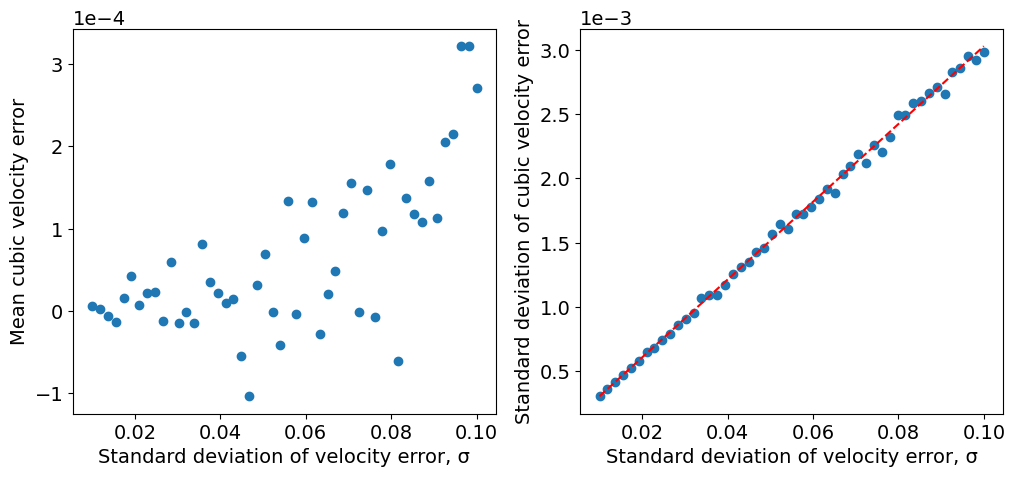

In [8]:
frame_a  = tools.imread('data/j0700/frame.01650.gray.1481p.png')
frame_b  = tools.imread('data/j0700/frame.01651.gray.1481p.png')
vel, dx, dy = pic2vel(frame_a, frame_b)
sigma = np.linspace(0.01, 0.1, 50)
avg = mean(cubic, 1000, sigma, vel/(151 * 0.02), 'gauss')
std = standard_deviation(cubic, 1000, sigma, vel/(151 * 0.02), 'gauss')
f, ax = plt.subplots(1, 2, figsize=(12,5))
x = np.linspace(0.01, 0.1, 100)
ax[0].scatter(sigma, avg)
ax[0].set_xlabel('Standard deviation of velocity error, σ')
ax[0].set_ylabel('Mean cubic velocity error')
ax[1].plot(x, np.sqrt(9*np.mean((vel/(151 * 0.02)) ** 4) / (2 * 91 * 93)) * x, 'r--')
ax[1].scatter(sigma, std)
ax[1].set_xlabel('Standard deviation of velocity error, σ')
ax[1].set_ylabel('Standard deviation of cubic velocity error')

In [10]:
cubic(vel / (151 * 0.02))

0.024327747688684107

In [12]:
energy(vel / (151 * 0.02))

0.7650012564803179

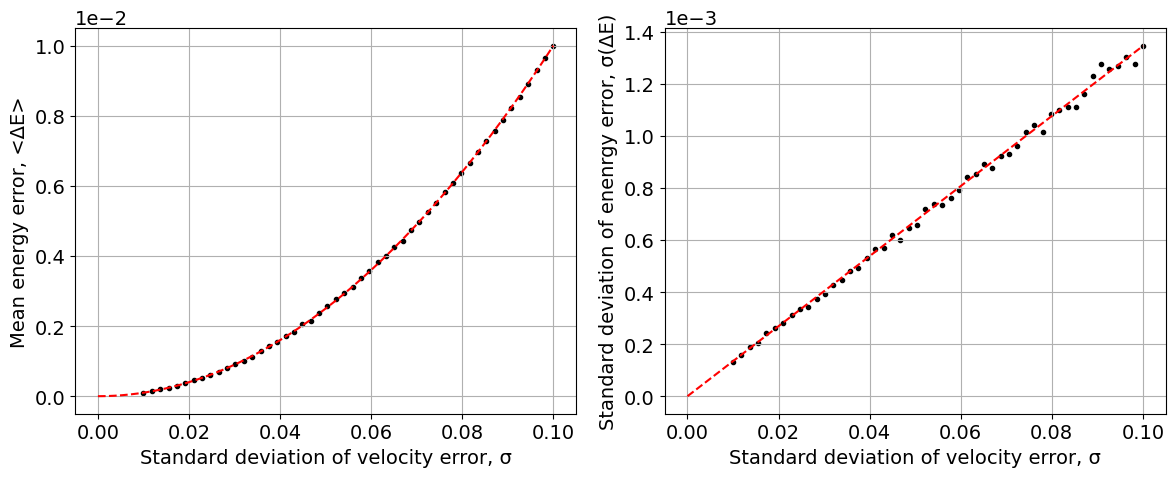

In [11]:
frame_a  = tools.imread('data/j0700/frame.01650.gray.1481p.png')
frame_b  = tools.imread('data/j0700/frame.01651.gray.1481p.png')
vel, dx, dy = pic2vel(frame_a, frame_b)
sigma = np.linspace(0.01, 0.1, 50)
avg = mean(energy, 1000, sigma, vel/(151 * 0.02), 'gauss')
std = standard_deviation(energy, 1000, sigma, vel/(151 * 0.02), 'gauss')
f, ax = plt.subplots(1, 2, figsize=(12,5))
x = np.linspace(0, 0.1, 1000)
ax[0].scatter(sigma, avg, color='black', marker='.')
ax[0].plot(x, x**2, 'r--')
ax[0].set_xlabel('Standard deviation of velocity error, σ')
ax[0].set_ylabel('Mean energy error, <ΔE>')
ax[1].scatter(sigma, std, color='black', marker='.')
ax[1].plot(x, np.sqrt(2 * energy(vel / (151 * 0.02)) / (vel.shape[2] * vel.shape[1])) * x, 'r--')
ax[1].set_xlabel('Standard deviation of velocity error, σ')
ax[1].set_ylabel('Standard deviation of enenrgy error, σ(ΔE)')
ax[1].grid()
ax[0].grid()
plt.tight_layout()

100%|██████████| 2/2 [03:12<00:00, 96.18s/it]


[0.77272852 0.82249633] [0.00387007 0.00428703] [0.00086537 0.00096741]


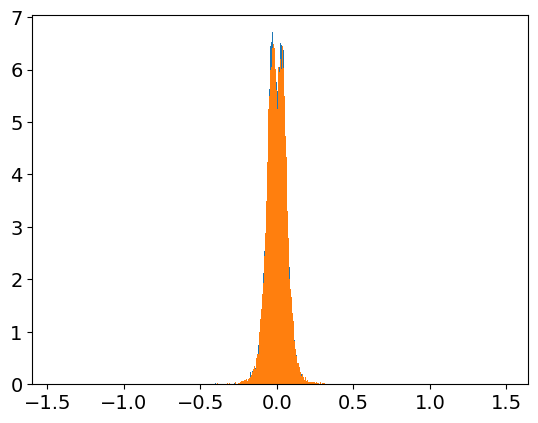

In [ ]:
t = np.arange(30, 60.01, 30)
full_energy = np.zeros(len(t))
energy_errormean = np.zeros(len(t))
energy_errordev = np.zeros(len(t))
for i in tqdm(range(len(t))):
  frame_a  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i) + '.gray.1481p.png')
  frame_b  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i + 1) + '.gray.1481p.png')
  full_energy[i], energy_errormean[i], energy_errordev[i] = pic2error(energy, frame_a, frame_b, 151, 0.02, error_type='cdf')
print(full_energy, energy_errormean, energy_errordev)

In [ ]:
t = np.arange(30, 60.01, 1)
full_energy = np.zeros(len(t))
energy_errormean = np.zeros(len(t))
energy_errordev = np.zeros(len(t))
for i in tqdm(range(len(t))):
  frame_a  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i) + '.gray.1481p.png')
  frame_b  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i + 1) + '.gray.1481p.png')
  full_energy[i], energy_errormean[i], energy_errordev[i] = pic2error(energy, frame_a, frame_b, 151, 0.02, error_type='gauss')


np.save('energy_errormean_j0700', energy_errormean)
np.save('energy_errordev_j0700', energy_errordev)
np.save('energy_j0700', full_energy)
#files.download('energy_j0700.npy')
#files.download('energy_errormean_j0700.npy')
#files.download('energy_errordev_j0700.npy')
print(full_energy, energy_errormean, energy_errordev)

100%|██████████| 31/31 [17:28<00:00, 33.82s/it]

[0.77272852 0.82249633 0.78490124 0.76500126 0.74215661 0.75863783
 0.74335588 0.77903811 0.82580242 0.84574719 0.81768319 0.7639929
 0.73467958 0.78443437 0.77560864 0.80510323 0.81012313 0.82133553
 0.86257991 0.74620178 0.76615886 0.74726723 0.79367141 0.79402201
 0.78101846 0.7408566  0.75295088 0.79442775 0.84842939 0.85214926
 0.78479294] [0.00374089 0.00456924 0.00402349 0.00400704 0.00370762 0.00353608
 0.00442476 0.00430399 0.00426513 0.0042565  0.0032903  0.00405356
 0.0046502  0.00420563 0.00411705 0.00372574 0.00364998 0.00404041
 0.00395248 0.00374542 0.0034543  0.00376552 0.00334848 0.00391142
 0.00391641 0.00396265 0.00371011 0.00457557 0.00412055 0.00456639
 0.00438518] [0.00079796 0.00095919 0.00085097 0.00083464 0.00080842 0.00080449
 0.00085773 0.00086982 0.00091217 0.00091631 0.00079992 0.00085711
 0.00094225 0.00090404 0.00088806 0.00080795 0.00084319 0.00086598
 0.00088552 0.00078477 0.00077662 0.00080166 0.00075287 0.00086329
 0.00085845 0.00083161 0.0007982  0.0

In [ ]:
en_j0070 = np.load('/content/drive/MyDrive/expdata/energy_j0070.npy')
en_j0250 = np.load('/content/drive/MyDrive/expdata/energy_j0250.npy')
en_j0460 = np.load('/content/drive/MyDrive/expdata/energy_j0460.npy')
en_j0580 = np.load('/content/drive/MyDrive/expdata/energy_j0580.npy')
en_j0700 = np.load('/content/drive/MyDrive/expdata/energy_j0700.npy')
en_errormean_j0070 = np.load('/content/drive/MyDrive/expdata/energy_errormean_j0070.npy')
en_errormean_j0250 = np.load('/content/drive/MyDrive/expdata/energy_errormean_j0250.npy')
en_errormean_j0460 = np.load('/content/drive/MyDrive/expdata/energy_errormean_j0460.npy')
en_errormean_j0580 = np.load('/content/drive/MyDrive/expdata/energy_errormean_j0580.npy')
en_errormean_j0700 = np.load('/content/drive/MyDrive/expdata/energy_errormean_j0700.npy')
en_errordev_j0070 = np.load('/content/drive/MyDrive/expdata/energy_errordev_j0070.npy')
en_errordev_j0250 = np.load('/content/drive/MyDrive/expdata/energy_errordev_j0250.npy')
en_errordev_j0460 = np.load('/content/drive/MyDrive/expdata/energy_errordev_j0460.npy')
en_errordev_j0580 = np.load('/content/drive/MyDrive/expdata/energy_errordev_j0580.npy')
en_errordev_j0700 = np.load('/content/drive/MyDrive/expdata/energy_errordev_j0700.npy')
mean_j0070 = np.mean(en_errormean_j0070)
mean_j0250 = np.mean(en_errormean_j0250)
mean_j0460 = np.mean(en_errormean_j0460)
mean_j0580 = np.mean(en_errormean_j0580)
mean_j0700 = np.mean(en_errormean_j0700)
dev_j0070 = np.std(en_errormean_j0070)
dev_j0250 = np.std(en_errormean_j0250)
dev_j0460 = np.std(en_errormean_j0460)
dev_j0580 = np.std(en_errormean_j0580)
dev_j0700 = np.std(en_errormean_j0700)
errormean_j0070 = np.mean(en_errordev_j0070)
errormean_j0250 = np.mean(en_errordev_j0250)
errormean_j0460 = np.mean(en_errordev_j0460)
errormean_j0580 = np.mean(en_errordev_j0580)
errormean_j0700 = np.mean(en_errordev_j0700)
errordev_j0070 = np.std(en_errordev_j0070)
errordev_j0250 = np.std(en_errordev_j0250)
errordev_j0460 = np.std(en_errordev_j0460)
errordev_j0580 = np.std(en_errordev_j0580)
errordev_j0700 = np.std(en_errordev_j0700)

100%|██████████| 31/31 [24:11<00:00, 46.81s/it]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[ 5.22239279e-05  3.36643962e-05  1.05079685e-05 -6.73063685e-06
 -1.82273344e-05  4.54832078e-05 -5.59668467e-06  3.67591742e-05
  1.85560454e-05 -3.28937959e-05 -3.71476080e-05  1.28120397e-06
 -9.92809825e-05 -8.79851708e-05  5.25343171e-05 -2.46194881e-05
 -5.04837314e-05  1.38622007e-05 -3.41228612e-05  1.39428910e-05
 -9.85579697e-05 -7.12888464e-05 -7.80356754e-05 -6.10453965e-05
 -3.90880203e-06  3.03893916e-05 -9.48846735e-05 -2.57252813e-05
 -1.26371041e-04 -4.86480012e-06  1.18303455e-06] [0.00160577 0.00202213 0.00180241 0.00175203 0.0015189  0.0015842
 0.00185391 0.00188774 0.00208296 0.00187405 0.00164096 0.00172825
 0.00182461 0.00177806 0.00183199 0.00166792 0.00169411 0.00177728
 0.00184011 0.00153164 0.00159235 0.001668   0.00157241 0.00164776
 0.001797   0.00167623 0.00156651 0.00185819 0.00183729 0.00197731
 0.00189532]


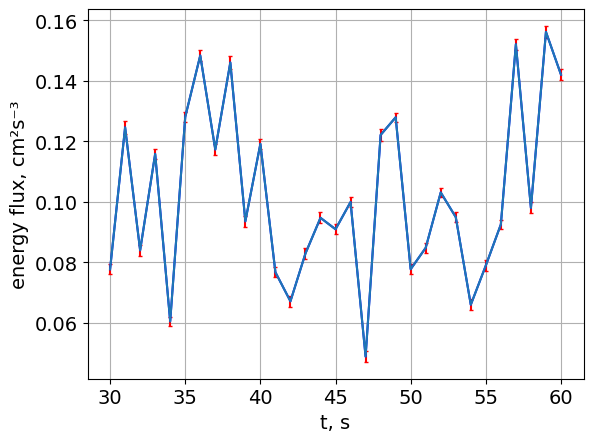

In [ ]:
t = np.arange(30, 60.01, 1)
flux = np.zeros(len(t))
flux_errormean = np.zeros(len(t))
flux_errordev = np.zeros(len(t))
for i in tqdm(range(len(t))):
  frame_a  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i) + '.gray.1481p.png')
  frame_b  = tools.imread('data/j0700/frame.0' + str(1500 + 50*i + 1) + '.gray.1481p.png')
  flux[i], flux_errormean[i], flux_errordev[i] = pic2error(energy_flux, frame_a, frame_b, 151, 0.02, error_type='gauss')

plt.errorbar(t, flux, yerr=flux_errordev, capsize=1.5, ecolor='red')
plt.plot(t, flux, color='blue')
plt.xlabel('t, s')
plt.ylabel('energy flux, cm²s⁻³')
plt.grid()
plt.savefig('flux_j0700_itgauss.png', dpi=500)
np.save('flux_errormean_j0700_itgauss', flux_errormean)
np.save('flux_errordev_j0700_itgauss', flux_errordev)
np.save('flux_j0700_itgauss', flux)
files.download('flux_j0700_itgauss.npy')
files.download('flux_j0700_itgauss.png')
files.download('flux_errormean_j0700_itgauss.npy')
files.download('flux_errordev_j0700_itgauss.npy')
print(flux_errormean, flux_errordev)

Стандартное отклонение погрешности поля скорости:

In [ ]:
t = np.arange(30, 60.01, 1)
dv_std = np.zeros(len(t))
for i in tqdm(range(len(t))):
  frame_a  = tools.imread('data/j0070/frame.0' + str(1500 + 50*i) + '.gray.1481p.png')
  frame_b  = tools.imread('data/j0070/frame.0' + str(1500 + 50*i + 2) + '.gray.1481p.png')
  vel, x, y = pic2vel(frame_a, frame_b)
  def_vel = deformation_field(vel)
  image_a_new = deform_image(frame_a, x, y, def_vel[0, :, :], def_vel[1, :, :])
  image_b_new = deform_image(frame_b, x, y, -def_vel[0, :, :], -def_vel[1, :, :])
  vel_field_art, x_art, y_art = pic2vel(frame_a, image_a_new)
  vel_field_art_inv, x_art_inv, y_art_inv = pic2vel(image_b_new, frame_b)
  delta_v = np.concatenate((def_vel - vel_field_art, def_vel - vel_field_art_inv)) / (151 * 0.04)
  dv_std[i] = np.std(delta_v)
delta_v_std = np.mean(dv_std)
print(dv_std, delta_v_std)

100%|██████████| 31/31 [16:13<00:00, 31.42s/it]

[0.02058465 0.02042295 0.02044265 0.02059584 0.02055743 0.02056404
 0.02068791 0.0207247  0.02100355 0.02106819 0.02101658 0.02093744
 0.02097892 0.02113161 0.02069198 0.02089006 0.0208728  0.02093684
 0.02067875 0.02058345 0.02055747 0.02055506 0.02049038 0.02056582
 0.0205837  0.02066225 0.02051983 0.02058983 0.0204779  0.02051007
 0.02043477] 0.020687659762573894


[0.02002568 0.01987566] 0.01995067117861047


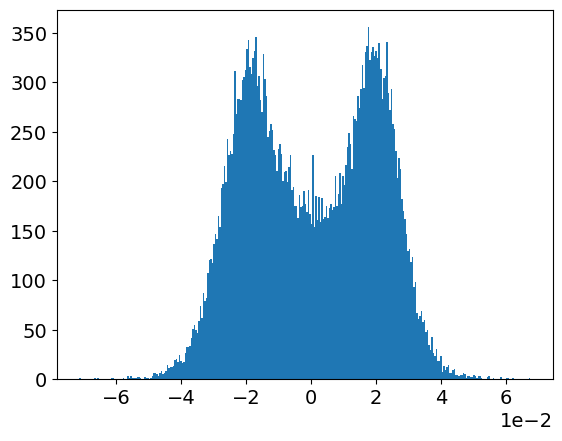

In [ ]:
x = plt.hist(delta_v.flatten(), bins=300)
print(dv_std, delta_v_std)

In [22]:
def power(x, a, b):
  return a + b * x

[0.06201313 0.03287717] [0.00495674 0.00168845]


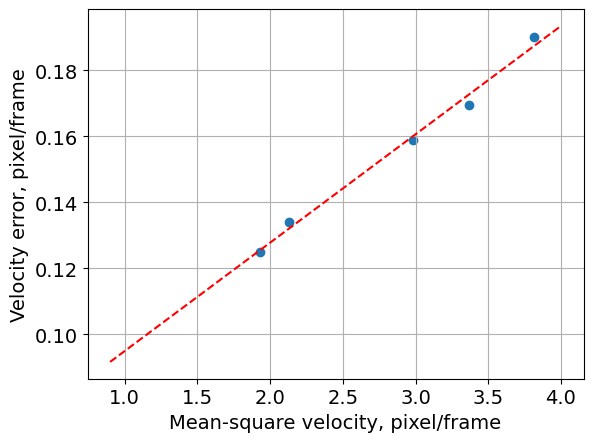

In [ ]:
std_deltav = np.array([0.020687659762573894 * 2, 0.044371102165621665, 0.052664903003453604, 0.05618424719299955, 0.0630015887136924])
Re = np.array([53.16 * 2, 117.49, 164.17, 185.71, 210.33])
meansq_vel = Re * 0.0085 / np.sqrt(2)
popt,pcov = curve_fit(power, meansq_vel * (151 * 0.02), std_deltav * (151 * 0.02))
plt.scatter(meansq_vel * (151 * 0.02), std_deltav * (151 * 0.02))
x = np.linspace(0.9, 4, 1000)
plt.plot(x, power(x,popt[0], popt[1]), 'r--')
plt.grid()
plt.xlabel('Mean-square velocity, pixel/frame')
plt.ylabel('Velocity error, pixel/frame')
print(popt, np.sqrt(np.diag(pcov)))

Верификация алгоритма:

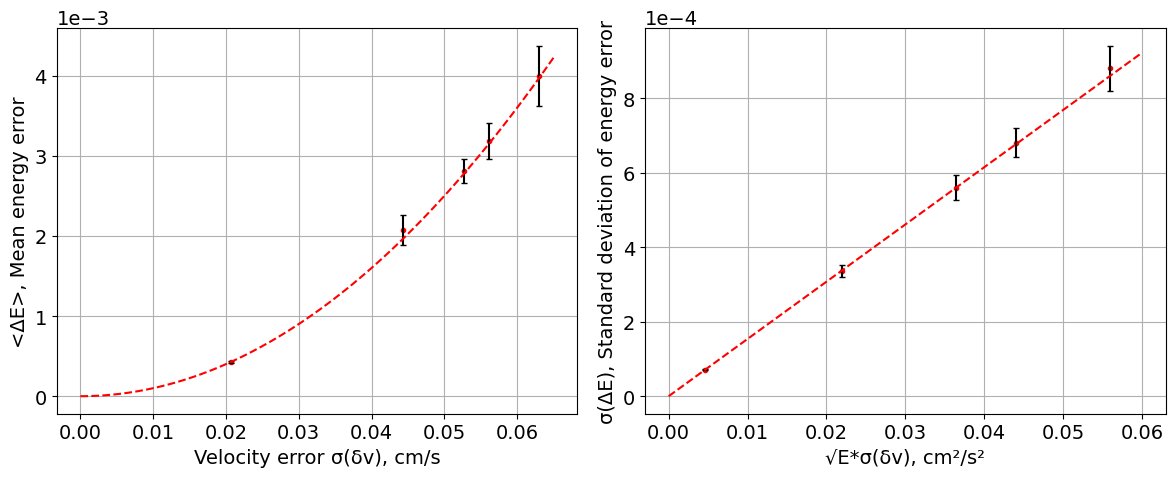

In [ ]:
mean_energy_error = np.array([mean_j0070, mean_j0250, mean_j0460, mean_j0580, mean_j0700])
std_energy_error = np.array([errormean_j0070, errormean_j0250, errormean_j0460, errormean_j0580, errormean_j0700])
sigma_mean = np.array([dev_j0070, dev_j0250, dev_j0460, dev_j0580, dev_j0700])
sigma_std = np.array([errordev_j0070, errordev_j0250, errordev_j0460, errordev_j0580, errordev_j0700])
energy0 = np.array([np.mean(en_j0070), np.mean(en_j0250), np.mean(en_j0460), np.mean(en_j0580), np.mean(en_j0700)])
x = np.linspace(0, 0.065, 100)
y = np.linspace(0, 0.06, 100)
f, ax = plt.subplots(1,2, figsize=(12, 5))
ax[0].errorbar(std_deltav, mean_energy_error, yerr=sigma_mean, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[0].plot(x, x**2, 'r--')
ax[0].grid()
ax[0].set_xlabel('Velocity error σ(δv), cm/s')
ax[0].set_ylabel('<ΔE>, Mean energy error')
ax[1].errorbar(np.sqrt(energy0) * std_deltav, std_energy_error, yerr=sigma_std, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[1].plot(y, np.sqrt(2)*y/np.sqrt(91*93), 'r--')
ax[1].set_xlabel('√E*σ(δv), cm²/s²')
ax[1].set_ylabel('σ(ΔE), Standard deviation of energy error')
ax[1].grid()

plt.tight_layout()

Результаты для спектрального потока энергии:

In [18]:
flux_j0070 = np.load('/content/drive/MyDrive/expdata/flux_j0070.npy')
flux_j0250 = np.load('/content/drive/MyDrive/expdata/flux_j0250.npy')
flux_j0460 = np.load('/content/drive/MyDrive/expdata/flux_j0460.npy')
flux_j0580 = np.load('/content/drive/MyDrive/expdata/flux_j0580.npy')
flux_j0700 = np.load('/content/drive/MyDrive/expdata/flux_j0700.npy')
flux_errormean_j0070 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0070_itnew.npy')
flux_errormean_j0250 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0250_itnew.npy')
flux_errormean_j0460 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0460_itnew.npy')
flux_errormean_j0580 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0580_itnew.npy')
flux_errormean_j0700 = np.load('/content/drive/MyDrive/expdata/flux_errormean_j0700_itnew.npy')
flux_errordev_j0070 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0070_itnew.npy')
flux_errordev_j0250 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0250_itnew.npy')
flux_errordev_j0460 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0460_itnew.npy')
flux_errordev_j0580 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0580_itnew.npy')
flux_errordev_j0700 = np.load('/content/drive/MyDrive/expdata/flux_errordev_j0700_itnew.npy')
mean_j0070 = np.mean(flux_j0070)
mean_j0250 = np.mean(flux_j0250)
mean_j0460 = np.mean(flux_j0460)
mean_j0580 = np.mean(flux_j0580)
mean_j0700 = np.mean(flux_j0700)
dev_j0070 = np.std(flux_j0070)
dev_j0250 = np.std(flux_j0250)
dev_j0460 = np.std(flux_j0460)
dev_j0580 = np.std(flux_j0580)
dev_j0700 = np.std(flux_j0700)
errormean_j0070 = np.mean(flux_errordev_j0070)
errormean_j0250 = np.mean(flux_errordev_j0250)
errormean_j0460 = np.mean(flux_errordev_j0460)
errormean_j0580 = np.mean(flux_errordev_j0580)
errormean_j0700 = np.mean(flux_errordev_j0700)
errordev_j0070 = np.std(flux_errordev_j0070)
errordev_j0250 = np.std(flux_errordev_j0250)
errordev_j0460 = np.std(flux_errordev_j0460)
errordev_j0580 = np.std(flux_errordev_j0580)
errordev_j0700 = np.std(flux_errordev_j0700)

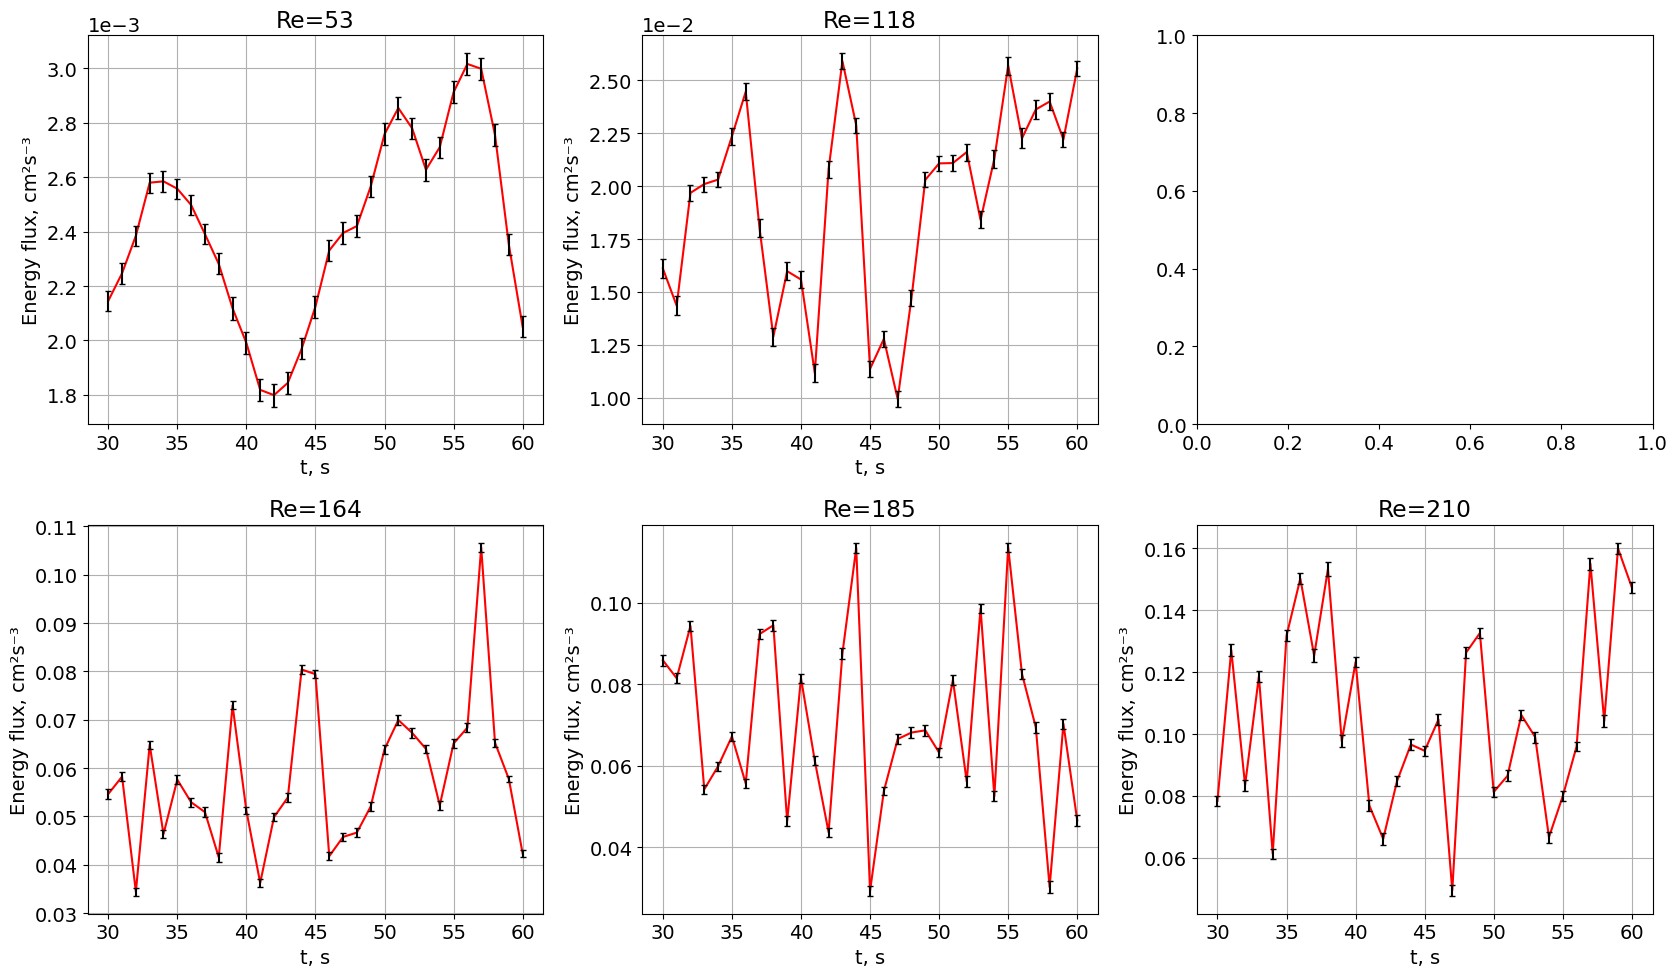

In [ ]:
f, ax = plt.subplots(2,3, figsize=(17,10))
t = np.arange(30, 60.01, 1)
ax[0,0].errorbar(t, flux_j0070, yerr=flux_errordev_j0070, ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[0,1].errorbar(t, flux_j0250, yerr=flux_errordev_j0250, ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[1,0].errorbar(t, flux_j0460, yerr=flux_errordev_j0460, ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[1,1].errorbar(t, flux_j0580, yerr=flux_errordev_j0580, ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[1,2].errorbar(t, flux_j0700, yerr=flux_errordev_j0700, ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[0,0].grid()
ax[1,0].grid()
ax[0,1].grid()
ax[1,1].grid()
ax[1,2].grid()
ax[0,0].set_xlabel('t, s')
ax[0,0].set_ylabel('Energy flux, cm²s⁻³')
ax[1,0].set_xlabel('t, s')
ax[1,0].set_ylabel('Energy flux, cm²s⁻³')
ax[0,1].set_xlabel('t, s')
ax[0,1].set_ylabel('Energy flux, cm²s⁻³')
ax[1,1].set_xlabel('t, s')
ax[1,1].set_ylabel('Energy flux, cm²s⁻³')
ax[1,2].set_xlabel('t, s')
ax[1,2].set_ylabel('Energy flux, cm²s⁻³')
ax[0,0].set_title('Re=53')
ax[1,0].set_title('Re=164')
ax[0,1].set_title('Re=118')
ax[1,1].set_title('Re=185')
ax[1,2].set_title('Re=210')
plt.tight_layout()

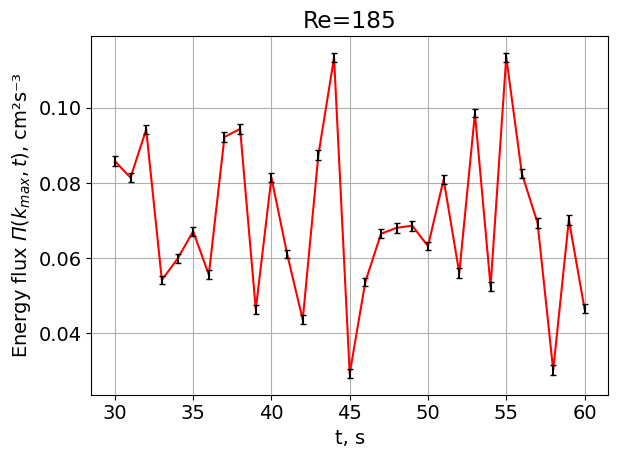

In [ ]:
t = np.arange(30, 60.01, 1)
plt.errorbar(t, flux_j0580, yerr=flux_errordev_j0580, ecolor='black', capsize=2, color = 'r', barsabove = 'True')
plt.grid()
plt.xlabel('t, s')
plt.ylabel('Energy flux $П(k_{max},t)$, cm²s⁻³')
plt.title('Re=185')
plt.tight_layout()

In [16]:
def power(x, a, b):
  return a * x ** b

[1.63044915 2.05464574 1.55304444 1.74738427 1.68804116]
[0.45797575 0.77669511 0.52849675 0.42745151 0.48532855]
[4.33061345e-08 2.74751500e+00] [3.21941309e-09 1.51565879e-02]
[7.73752507e-10 3.27469519e+00] [1.58429524e-11 4.16567723e-03]


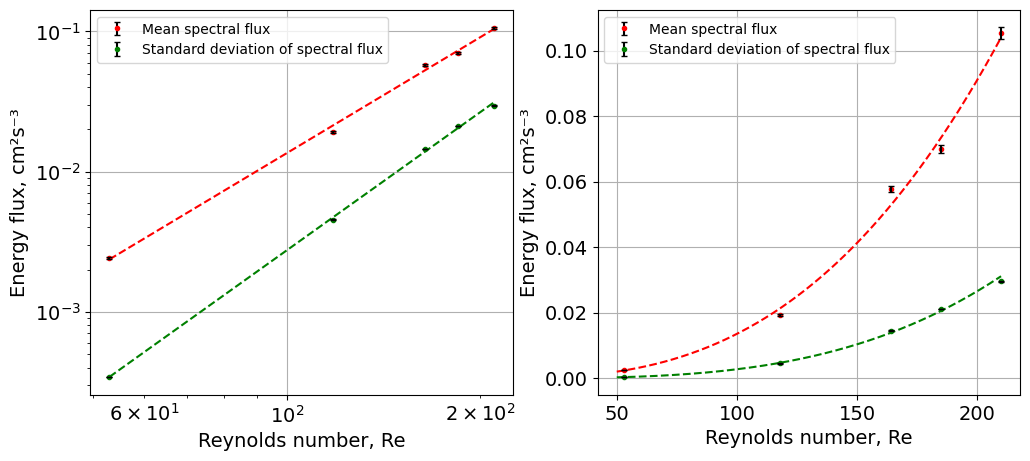

In [19]:
Re = np.array([53, 118, 164, 185, 210])
meanP = np.array([mean_j0070, mean_j0250, mean_j0460, mean_j0580, mean_j0700])
stdP = np.array([dev_j0070, dev_j0250, dev_j0460, dev_j0580, dev_j0700])
mean_error = np.array([errormean_j0070, errormean_j0250, errormean_j0460, errormean_j0580, errormean_j0700])
dev_error = np.array([errordev_j0070, errordev_j0250, errordev_j0460, errordev_j0580, errordev_j0700])
param_mean = curve_fit(power, Re, meanP, sigma=mean_error, absolute_sigma='True')
param_std = curve_fit(power, Re, stdP, sigma=dev_error, absolute_sigma='True')
f, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(Re, param_mean[0][0] * Re ** param_mean[0][1], 'r--')
ax[0].plot(Re, param_std[0][0] * Re ** param_std[0][1], 'g--')
ax[0].errorbar(Re, meanP, yerr=mean_error, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True', label = 'Mean spectral flux')
ax[0].errorbar(Re, stdP, yerr=dev_error, fmt=".", ecolor='black', capsize=2, color = 'g', barsabove = 'True', label = 'Standard deviation of spectral flux')
ax[0].set_yscale('log')
ax[0].set_xscale('log')
ax[0].set_xlabel('Reynolds number, Re')
ax[0].set_ylabel('Energy flux, cm²s⁻³')
ax[0].legend(prop={'size': 10})
ax[0].grid()
reynolds = np.linspace(50, 210, 1000)
ax[1].plot(reynolds, param_mean[0][0] * reynolds ** param_mean[0][1], 'r--')
ax[1].plot(reynolds, param_std[0][0] * reynolds ** param_std[0][1], 'g--')
ax[1].errorbar(Re, meanP, yerr=mean_error, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True', label = 'Mean spectral flux')
ax[1].errorbar(Re, stdP, yerr=dev_error, fmt=".", ecolor='black', capsize=2, color = 'g', barsabove = 'True', label = 'Standard deviation of spectral flux')
ax[1].set_xlabel('Reynolds number, Re')
ax[1].set_ylabel('Energy flux, cm²s⁻³')
ax[1].legend(prop={'size': 10})
ax[1].grid()

print(mean_error/meanP * 100)
print(dev_error/stdP * 100)
print(param_mean[0], np.sqrt(np.diag(param_mean[1])))
print(param_std[0], np.sqrt(np.diag(param_std[1])))

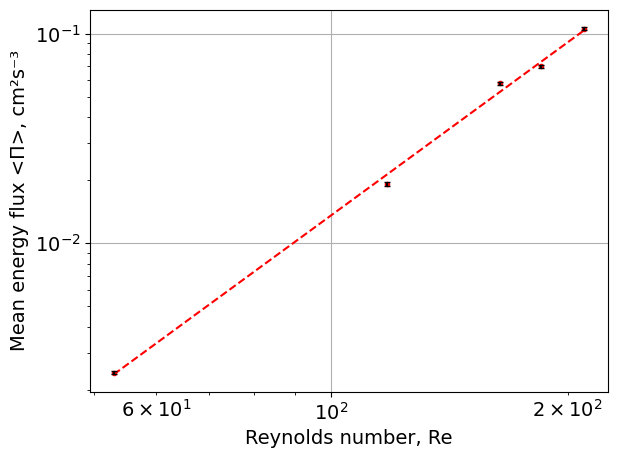

In [ ]:
Re = np.array([53, 118, 164, 185, 210])
meanP = np.array([mean_j0070, mean_j0250, mean_j0460, mean_j0580, mean_j0700])
stdP = np.array([dev_j0070, dev_j0250, dev_j0460, dev_j0580, dev_j0700])
mean_error = np.array([errormean_j0070, errormean_j0250, errormean_j0460, errormean_j0580, errormean_j0700])
dev_error = np.array([errordev_j0070, errordev_j0250, errordev_j0460, errordev_j0580, errordev_j0700])
param_mean = curve_fit(power, Re, meanP, sigma=mean_error, absolute_sigma='True')
param_std = curve_fit(power, Re, stdP, sigma=dev_error, absolute_sigma='True')
plt.plot(Re, param_mean[0][0] * Re ** param_mean[0][1], 'r--')
plt.errorbar(Re, meanP, yerr=mean_error, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True', label = 'Mean spectral flux')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Reynolds number, Re')
plt.ylabel('Mean energy flux <П>, cm²s⁻³')
plt.grid()
plt.tight_layout()

In [14]:
j0070 = [0.02058465,0.02042295,0.02044265,0.02059584,0.02055743,0.02056404
,0.02068791,0.0207247,0.02100355,0.02106819,0.02101658,0.02093744
,0.02097892,0.02113161,0.02069198,0.02089006,0.0208728,0.02093684
,0.02067875,0.02058345,0.02055747,0.02055506,0.02049038,0.02056582
,0.0205837,0.02066225,0.02051983,0.02058983,0.0204779,0.02051007
,0.02043477]
j0250 = [0.04539438,0.04505115,0.0441478,0.04417413,0.04384526,0.04399585
,0.04416644,0.04459695,0.04450132,0.04434123,0.0438663,0.04436801
,0.0445232,0.04433031,0.04335723,0.0427653,0.04308564,0.04365529
,0.04391459,0.04408876,0.04399195,0.04404623,0.04452803,0.0451403
,0.04532489,0.04598499,0.04602365,0.04568531,0.04429238,0.04425506
,0.04406223]
j0460 = [0.05418852,0.05215006,0.05216255,0.05101928,0.05086968,0.05192362
,0.05392344,0.05300832,0.05323851,0.05183835,0.05108537,0.05099335
,0.05157173,0.05602934,0.05438707,0.05328757,0.05203549,0.05085249
,0.05162943,0.05361113,0.05279494,0.05315173,0.053715,0.0533046
,0.05373638,0.05404182,0.05267771,0.05502557,0.05192584,0.05081683
,0.05161628]
j0580 = [0.05625093,0.05719788,0.05934237,0.05285431,0.05421587,0.0538428
,0.05368628,0.05558744,0.05715372,0.05717248,0.05475234,0.05359994
,0.05709333,0.05620352,0.05691356,0.0564981,0.05385842,0.05484633
,0.05674731,0.05952662,0.05510923,0.05517427,0.0578764,0.05484618
,0.05647938,0.05495907,0.05565324,0.05817025,0.06143848,0.05759898
,0.05706264]
j0700 = [0.06012167,0.06738925,0.06328826,0.06306197,0.06122889,0.05938232
,0.06622235,0.06520273,0.06564527,0.06489405,0.05747183,0.06344161
,0.06765877,0.06539033,0.06436381,0.06122963,0.06014386,0.06282545
,0.06276533,0.06084093,0.05862719,0.06088611,0.05781085,0.06241489
,0.06225476,0.06287528,0.060755,0.0677661,0.06427221,0.06753621
,0.06528233]
error_deltav = np.array([np.std(j0070) * 2, np.std(j0250), np.std(j0460), np.std(j0580), np.std(j0700)])
print(error_deltav)

[0.00041037 0.00074959 0.00132328 0.00189959 0.0028531 ]


[0.0649628  0.85002944] [0.0006097  0.01531272]
[4.37542791e-05 2.76806438e+00] [1.65832394e-06 4.73431499e-02]


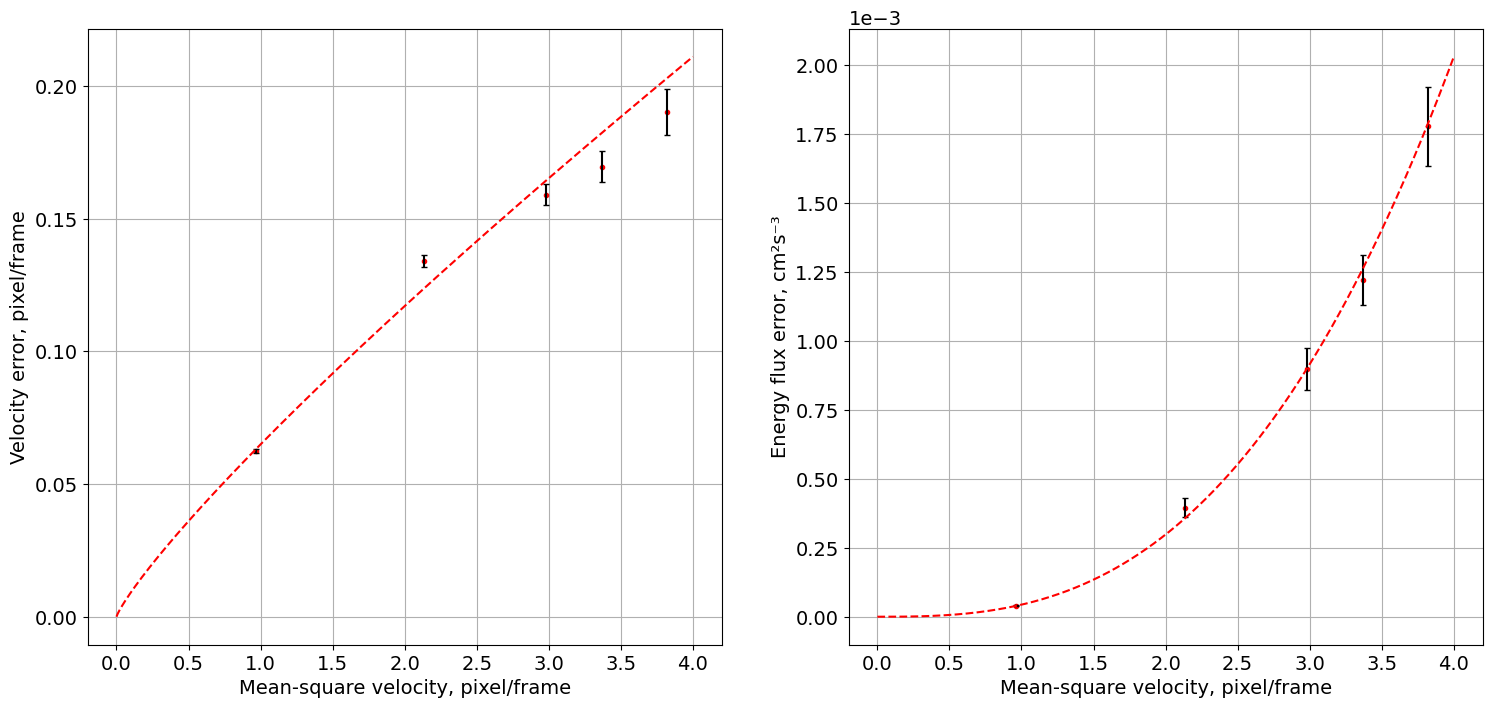

In [ ]:
std_deltav = np.array([0.020687659762573894, 0.044371102165621665, 0.052664903003453604, 0.05618424719299955, 0.0630015887136924])
Re = np.array([53.16, 117.49, 164.17, 185.71, 210.33])
meansq_vel = Re * 0.0085 / np.sqrt(2)
popt,pcov = curve_fit(power, meansq_vel * (151 * 0.02), std_deltav * (151 * 0.02), sigma=error_deltav * (151 * 0.02), absolute_sigma='True')
flux_opt, flux_cov = curve_fit(power, meansq_vel * (151 * 0.02), mean_error, sigma=dev_error, absolute_sigma='True')
x = np.linspace(0, 4, 1000)
f, ax = plt.subplots(1,2, figsize=(18,8))
ax[0].errorbar(meansq_vel * (151 * 0.02), std_deltav * (151 * 0.02), yerr=error_deltav * (151 * 0.02), fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[0].plot(x, power(x,popt[0], popt[1]), 'r--')
ax[0].grid()
ax[0].set_xlabel('Mean-square velocity, pixel/frame')
ax[0].set_ylabel('Velocity error, pixel/frame')
ax[1].errorbar(meansq_vel * (151 * 0.02), mean_error, yerr=dev_error, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True')
ax[1].plot(x, power(x,flux_opt[0], flux_opt[1]), 'r--')
ax[1].grid()
ax[1].set_xlabel('Mean-square velocity, pixel/frame')
ax[1].set_ylabel('Energy flux error, cm²s⁻³')

print(popt, np.sqrt(np.diag(pcov)))
print(flux_opt, np.sqrt(np.diag(flux_cov)))

[0.06639704 0.82890174] [0.00117458 0.02125011]
[6.63091903e-10 2.76806438e+00] [1.43657644e-10 4.73431436e-02]


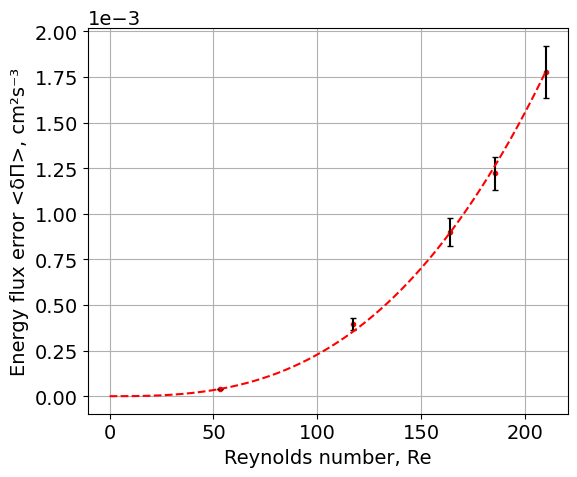

In [20]:
std_deltav = np.array([0.020687659762573894, 0.044371102165621665, 0.052664903003453604, 0.05618424719299955, 0.0630015887136924])
Re = np.array([53.16, 117.49, 164.17, 185.71, 210.33])
meansq_vel = Re * 0.0085 / np.sqrt(2)
popt,pcov = curve_fit(power, meansq_vel * (151 * 0.02), std_deltav * (151 * 0.02), sigma=error_deltav * (151 * 0.02), absolute_sigma='True')
flux_opt, flux_cov = curve_fit(power, Re, mean_error, sigma=dev_error, absolute_sigma='True')
x = np.linspace(0, 210, 1000)
f, ax = plt.subplots(1,1, figsize=(6, 5))
plt.errorbar(Re, mean_error, yerr=dev_error, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True')
plt.plot(x, power(x,flux_opt[0], flux_opt[1]), 'r--')
plt.grid()
plt.xlabel('Reynolds number, Re')
plt.ylabel('Energy flux error <ẟП>, cm²s⁻³')

plt.tight_layout()
print(popt, np.sqrt(np.diag(pcov)))
print(flux_opt, np.sqrt(np.diag(flux_cov)))

[0.06248314 0.03261346] [0.00544383 0.00253024]


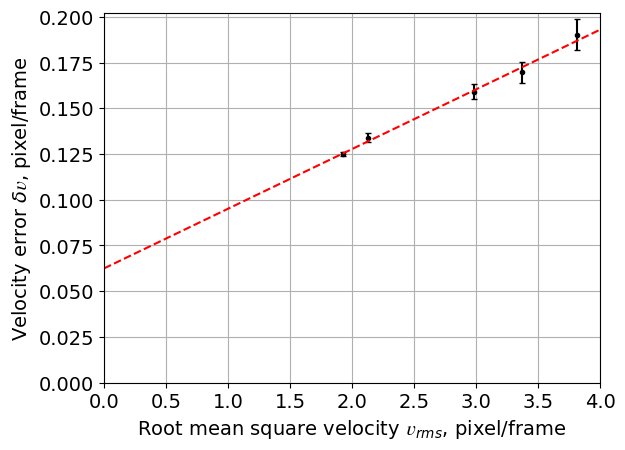

In [26]:
std_deltav = np.array([0.020687659762573894 * 2, 0.044371102165621665, 0.052664903003453604, 0.05618424719299955, 0.0630015887136924])
Re = np.array([53.16 * 2, 117.49, 164.17, 185.71, 210.33])
meansq_vel = Re * 0.0085 / np.sqrt(2)
popt,pcov = curve_fit(power, meansq_vel * (151 * 0.02), std_deltav * (151 * 0.02), sigma=error_deltav * (151 * 0.02), absolute_sigma='True')

x = np.linspace(0, 4, 1000)
plt.errorbar(meansq_vel * (151 * 0.02), std_deltav * (151 * 0.02), yerr=error_deltav * (151 * 0.02), fmt=".", ecolor='black', capsize=2, color = 'black', barsabove = 'True')
plt.plot(x, power(x,popt[0], popt[1]), 'r--')
plt.grid()
plt.xlabel('Root mean square velocity $𝑣_{rms}$, pixel/frame')
plt.ylabel('Velocity error $ẟ𝑣$, pixel/frame')
plt.ylim([0, 0.202])
plt.xlim([0, 4])

print(popt, np.sqrt(np.diag(pcov)))

[0.42091179 3.35211165] [0.05984892 0.060359  ]


Text(0, 0.5, 'Energy flux error, cm²s⁻³')

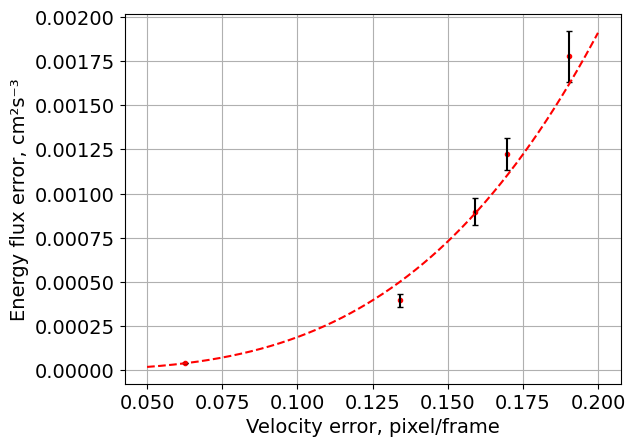

In [ ]:
params = curve_fit(power, std_deltav * (151 * 0.02), mean_error, sigma=dev_error, absolute_sigma='True')
plt.errorbar(std_deltav * (151 * 0.02), mean_error, yerr=dev_error, fmt=".", ecolor='black', capsize=2, color = 'r', barsabove = 'True')
x = np.linspace(0.05, 0.2, 1000)
print(params[0], np.sqrt(np.diag(params[1])))
plt.plot(x, power(x, params[0][0], params[0][1]), 'r--')
plt.grid()
plt.xlabel('Velocity error, pixel/frame')
plt.ylabel('Energy flux error, cm²s⁻³')

In [ ]:
plt.scatter(std_deltav * (151 * 0.02), mean_error)
pmeanopt, pmeancov = curve_fit(power, std_deltav * (151 * 0.02), mean_error)
x = np.linspace(0.01, 0.2, 1000)
plt.plot(x, power(x, *pmeanopt))
print(pmeanopt, np.sqrt(np.diag(pmeancov)))